# Binary Task SVM Notebook

### Contains Code for Binary task SVM Model creation, training and validation(hyperparameter tuning)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import pickle as pkl
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function (TO DO: include exception if tqdm not imported )
from tqdm import tqdm

#Importing libraries used for SVM classification and model assessment
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

#Importing functions notebook containing functions created to streamline code
from ipynb.fs.full.functions import load_dataset, dataset_PCA, Tuned_SVM_train, SVM_predictions


Using TensorFlow backend.


# 1. Loading Dataset and doing final preprocessing
### We Load the preprocessed data and carry out PCA on the image array here for the binary training and test data
## 1.1 Loading Datasets

In [3]:
X, Y = load_dataset('.\dataset\Image_DF_Flat.pkl', './dataset/Y_Binary_label.pkl')

Datasets successfully loaded with shapes:
Y Shape:
(3000,)
X Shape:
(3000, 784)


#### We can do PCA for the images but must be done separately for binary and multiclass task as the data must be split first
#### This is because we must do PCA on the training data only (fit and transform it) and then only use the transform on the test data to prevent bias
#### We select 400 components as it provides around 96% explained variance as shown previously.

## 1.2 Splitting data in to training and testing sets

In [4]:
# Split the data into training and testing(70% training and 30% testing data)
# In this case the testing data will be used as the validation dataset
# Validation in terms of using it to assess and tune the hyperparameter values
xTrain,xTest,yTrain,yTest=train_test_split(X, Y, train_size = 0.7)

#Rescaling the dataframe as the pixel values range from 0 to 255
#We want it to be between 0 to 1 for easier classification for SVM
xTrain_Scaled = xTrain/255
xTest_Scaled = xTest/255

## 1.3 PCA

In [5]:
#Initialising PCA with 400 components determined in preprocessing notebook
#Calls the dataset_PCA function defined in "functions.ipynb" to carry out PCa
#Input arguements are number of components, xTrain data and xTest data
#We put in the scaled X train and test data
xTrain_PCA, xTest_transformed = dataset_PCA(400, xTrain_Scaled, xTest_Scaled)

#Function returns the resultant explained variance percentage when we use 400 components.

PCA conducted with 400 components.
The percentage of Explained Variance of the dataset from PCA is: 96.52330598459868


# 2. Model Building

## 2.1 SVM without tuning
### 2.1.1 Training<br/> We first train SVM without hyperparameter tuning to assess the performance of the model with the training and test data

In [6]:
#Training model using SVC without hyperparameter tuning
binary_SVM_base = SVC()
binary_SVM_base.fit(xTrain_PCA, yTrain.values.ravel())

SVC()

### 2.1.2 Obtaining the Prediction results and performance<br/> Showing the confusion matrix and general assessment metrics using the classification report

In [7]:
#Calls SVM_predictions function from "functions.ipynb" to carry out the predictions using the base SVM model we made.
#It prints out the classification report of the predictions as well as the confusion matrix
#Returns the predictions
Binary_SVM_untuned_pred = SVM_predictions(binary_SVM_base, xTest_transformed, yTest)

The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.90      0.65      0.76       129
         1.0       0.94      0.99      0.97       771

    accuracy                           0.94       900
   macro avg       0.92      0.82      0.86       900
weighted avg       0.94      0.94      0.94       900

The confusion matrix is:
[[ 84  45]
 [  9 762]]


## 2.2 SVM with validation

### 2.2.1 Training<br/> We now use SVM again but with validation, tuning of the hyperparameter values<br/> This is done using an exhaustive Gridsearch of the parameter values given. <br/> After model is trained, we obtain the best parameters found by the gridsearch

In [8]:
#Using SVM but this time with gridsearch to tune hyperparameter

#Define the parameter ranges
#We test various values of:
# C
# gamma
# Type of Kernel to use
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','sigmoid','linear']
}

In [9]:
#Calls Tuned_SVM_train from "functions.ipynb" to conduct training and tuning of SVM model using gridsearch
#Full details on the input arguements listed in the functions notebook

#Function prints the resultant best hyperparameters found and new details of the model
#Returns the tuned model
Binary_SVM_Tuned = Tuned_SVM_train(param_grid, 10, xTrain_PCA, yTrain, False)

#est time = 5mins

Fitting 10 folds for each of 75 candidates, totalling 750 fits
Tuned SVM Model successfully trained and tuned
The best hyperparameters found by gridsearch are:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
The new model created after hyperparameter tuning is:
SVC(C=100, gamma=0.01)


### 2.2.2 Obtaining the Prediction results and performance<br/> Showing the confusion matrix and general assessment metrics using the classification report

In [10]:
#Calls SVM_predictions function from "functions.ipynb"
#This time we are doing predictions with the tuned SVM model
Binary_SVM_Tuned_pred = SVM_predictions(Binary_SVM_Tuned, xTest_transformed, yTest)

#It prints out the classification report of the predictions as well as the confusion matrix
#Returns the predictions

The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.76       129
         1.0       0.95      0.98      0.96       771

    accuracy                           0.94       900
   macro avg       0.90      0.84      0.86       900
weighted avg       0.94      0.94      0.94       900

The confusion matrix is:
[[ 89  40]
 [ 15 756]]


## 2.3 Comparing untuned and tuned SVM performance
### We utilise the ROC and AUC metrics to assess and compare the difference in performance of untuned and tuned SVM<br/> We show the ROC curve as well to visualise the difference in model performance.

In [17]:
#Using roc_curve method we obtain the various values pertinent to assessing accuracy for models, we take for both the Untuned and Tuned SVM model predictions
#Following which we also print the area under the ROC curve metric AUC. The higher the value the better the model

#Untuned SVM
FPR_Base_SVM, TPR_Base_SVM, Base_SVM_thres = roc_curve(yTest, Binary_SVM_untuned_pred)
print('roc_auc_score for Untuned SVM: ', roc_auc_score(yTest, Binary_SVM_untuned_pred))


#Tuned SVM
FPR_Tuned_SVM, TPR_Tuned_SVM_SVM, Tuned_SVM_SVM_thres = roc_curve(yTest, Binary_SVM_Tuned_pred)
print('roc_auc_score for Tuned SVM: ', roc_auc_score(yTest, Binary_SVM_Tuned_pred))


roc_auc_score for Untuned SVM:  0.8197448194733509
roc_auc_score for Tuned SVM:  0.8352336138509335


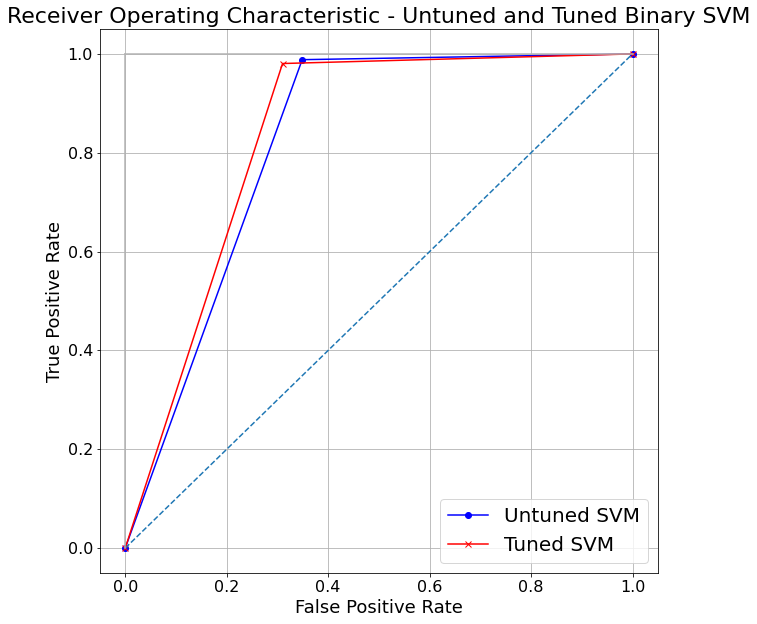

In [25]:
#We can visualise the ROC curve to see the two ROC curves for the untuned and tuned model.

plt.subplots(1, figsize=(10,10))
plt.grid()

#This plot is the base SVM model
plt.plot(FPR_Base_SVM, TPR_Base_SVM, linestyle='-', color='b', marker='o', label ="Untuned SVM")

#This plot is our tuned SVM model
plt.plot(FPR_Tuned_SVM, TPR_Tuned_SVM_SVM, linestyle='-', color='r', marker='x', label ="Tuned SVM")

#Optimal Model line
plt.plot([0, 1], ls="--")

#Diagonal Dotted Line
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

#Labels for title and axis
plt.title('Receiver Operating Characteristic - Untuned and Tuned Binary SVM', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=20)

#Saves plot to be used in the report
plt.savefig('./Plots/ROC_Binary_SVM.jpg', bbox_inches='tight')

## 2.4 Saving Trained model
### We save both trained SVM Models for easy reference and future use in an out of sample test dataset

In [15]:
#Saving tuned and base SVM models
save_path = "./Models/Binary-Classification"
Tuned_SVM_filename = 'Tuned_SVM_model.sav'
Base_SVM_filename = 'Untuned_SVM_model.sav'

#Using Pickle to save them in the Models folder
pkl.dump(binary_SVM_base , open(os.path.join(save_path, Base_SVM_filename), 'wb'))
pkl.dump(Binary_SVM_Tuned, open(os.path.join(save_path, Tuned_SVM_filename), 'wb'))


In [16]:
#Code to test loading of trained tuned SVM model
load_tuned_SVM = pkl.load(open('.\Models\Binary-Classification\Tuned_SVM_model.sav', 'rb'))
#Gets the best parameter values from loaded model
best_param = load_tuned_SVM.best_params_
#Prints out the parameter values
#Output should match earlier .best_params_ output
print(best_param)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
